In [ ]:
from geostat import GP, Model, Mesh, Parameters
import geostat
import geostat.kernel as krn
import matplotlib.pyplot as pp
import numpy as np

# Overview

In this notebook we will:
  * Use a Gaussian process to generate synthetic data with known geospatial parameters.
  * Use a second Gaussian process to infer the geospatial parameters from the synthetic data.
  * Use the fitted Gaussian process to interpolate locations on a mesh.

# Synthesizing data

We will synthesize data at mesh locations in a square centered on the origin.

First define mesh locations using a `Mesh` object. The `nx` argument specifies 80 mesh coordinates in the x direction, and keeps the pitch the same in the y direction (which results in 80 mesh coordinates in that direction as well).

In [2]:
mesh = Mesh.from_bounds([-1, -1, 1, 1], nx=80)

Declare the terms of the spatial trend. The decorator converts the function `trend_featurizer` into a featurizer that Geostat can use. The `normalize` argument causes each feature to have zero mean and unit variance after being applied to mesh locations. It also adds a constant one feature. The method `mesh.locations()` returns an array of shape `[N, 2]`, where `N` is the number of locations. 

In [3]:
@geostat.featurizer(normalize=mesh.locations())
def trend_featurizer(x, y): return x, y, x*x, x*y, y*y

Model parameters are specified here, along with their values. The return value `p` is a namespace.

In [4]:
p = Parameters(alpha=0.25, range=0.33, sill=1., nugget=0.25)

The covariance function has three terms:

  * `TrendPrior` specifies a trend based on `trend_featurizer`. In `TrendPrior`, `alpha` parameterizes the normal distribution prior for trend coefficients. 
  * `SquaredExponential`, a stationary covariance function.
  * `Noise`, uncorrelated noise.

In [5]:
kernel = krn.TrendPrior(trend_featurizer, alpha=p.alpha) + \
         krn.SquaredExponential(range=p.range, sill=p.sill) + \
         krn.Noise(nugget=p.nugget)

Define a Gaussian process with zero mean and a covariance function given by `kernel`.

In [6]:
gp = GP(0, kernel)

Instantiate a `Model` and then call `generate` to generate synthetic observations. The result `mesh_obs` has shape `[N]`.

In [7]:
model = Model(gp)
mesh_obs = model.generate(mesh.locations()).vals

When the data is plotted, you can see an overall trend with some localized variations. The method `mesh.slice()` forms the observations into a 2d array suitable for use with `pcolormesh`.

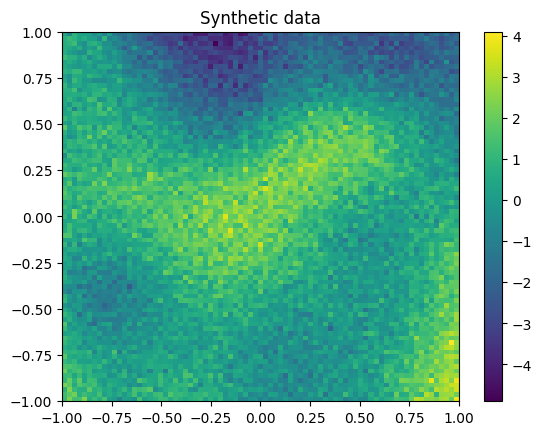

In [8]:
vmin, vmax = mesh_obs.min(), mesh_obs.max()
meshx, meshy, mesh_obs_2d = mesh.slice(mesh_obs) # Each return value is a 2d array.
c = pp.pcolormesh(meshx, meshy, mesh_obs_2d, vmin=vmin, vmax=vmax)
pp.colorbar(c)
pp.title('Synthetic data')
pp.show()

Of these synthetic datapoints we'll sample just 200, with which we'll try to reconstruct the rest of the data.

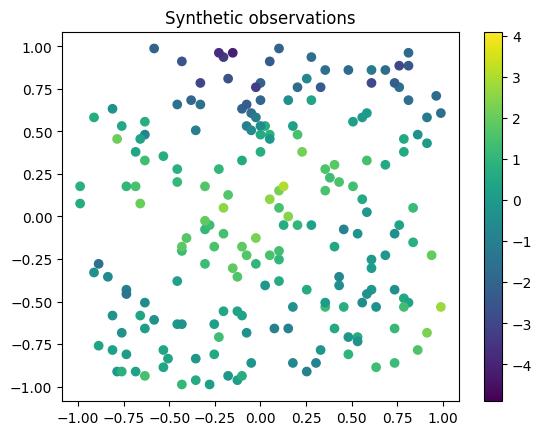

In [9]:
sample_indices = np.random.choice(len(mesh_obs), [200], replace=False)
locs = mesh.locations()[sample_indices, :]
obs = mesh_obs[sample_indices]

c = pp.scatter(locs[:, 0], locs[:, 1], c=obs, vmin=vmin, vmax=vmax)
pp.colorbar(c)
pp.title('Synthetic observations')
pp.show()

# Inferring parameters

Now we `set` the parameters in model to something arbitrary and see if the model can infer the correct parameters from the data, which consists of `locs` and `obs`. We don't expect `alpha` to converge to what it used to be, since `TrendPrior` generates only a small number of trend coefficients using `alpha`. However, `sill`, `range`, and `nugget` should all converge to something close.

(The `None` at the end suppresses extraneous output.)

In [10]:
model.set(alpha=1.0, range=1.0, sill=0.5, nugget=0.5)

model.fit(locs, obs, iters=500)

None

[iter    50 ll -237.51 time  1.86 reg  0.00 alpha  0.61 sill  0.84 range  0.60 nugget  0.56]
[iter   100 ll -200.69 time  0.59 reg  0.00 alpha  0.37 sill  1.24 range  0.42 nugget  0.34]
[iter   150 ll -194.76 time  0.59 reg  0.00 alpha  0.23 sill  1.44 range  0.37 nugget  0.26]
[iter   200 ll -194.28 time  0.58 reg  0.00 alpha  0.17 sill  1.48 range  0.36 nugget  0.25]
[iter   250 ll -194.12 time  0.58 reg  0.00 alpha  0.13 sill  1.47 range  0.36 nugget  0.25]
[iter   300 ll -194.05 time  0.58 reg  0.00 alpha  0.11 sill  1.46 range  0.35 nugget  0.25]
[iter   350 ll -194.01 time  0.58 reg  0.00 alpha  0.09 sill  1.46 range  0.35 nugget  0.25]
[iter   400 ll -194.00 time  0.58 reg  0.00 alpha  0.09 sill  1.46 range  0.35 nugget  0.25]
[iter   450 ll -193.99 time  0.58 reg  0.00 alpha  0.08 sill  1.47 range  0.35 nugget  0.25]
[iter   500 ll -193.99 time  0.58 reg  0.00 alpha  0.08 sill  1.48 range  0.36 nugget  0.25]


# Generating predictions

Call `model` to get predictions at the same mesh locations as before:

In [11]:
mean, var = model.predict(mesh.locations())

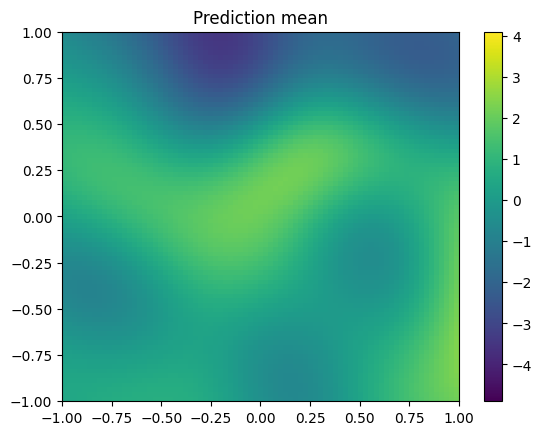

In [12]:
meshx, meshy, mean2d = mesh.slice(mean) # Each return value is a 2d array.
c = pp.pcolormesh(meshx, meshy, mean2d, vmin=vmin, vmax=vmax)
pp.colorbar(c)
pp.title('Prediction mean')
pp.show()

For comparison, here's the original synthetic data:

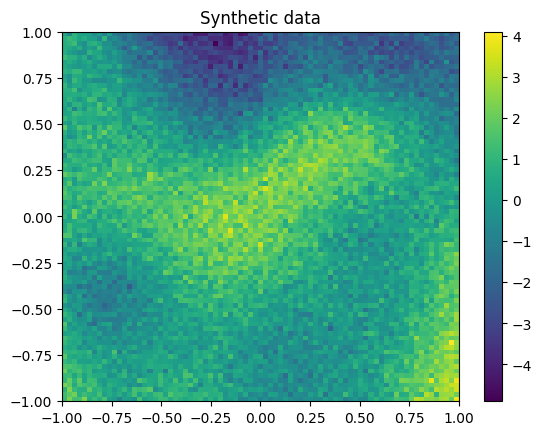

In [13]:
c = pp.pcolormesh(meshx, meshy, mesh_obs_2d, vmin=vmin, vmax=vmax)
pp.colorbar(c)
pp.title('Synthetic data')
pp.show()

And here's a plot of prediction variance, which accounts for, among other things, the noise that the model is unable to reconstruct.

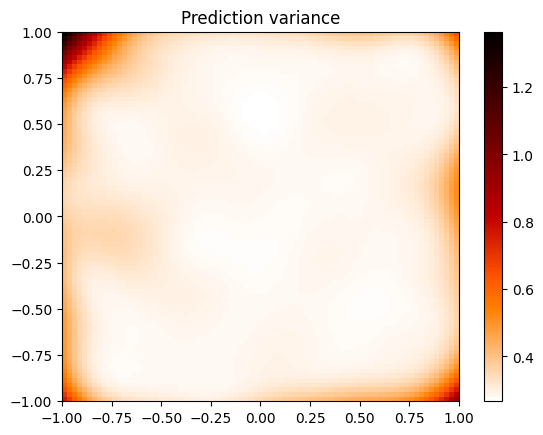

In [14]:
meshx, meshy, var2d = mesh.slice(var) # Each return value is a 2d array.
c = pp.pcolormesh(meshx, meshy, var2d, cmap='gist_heat_r')
pp.colorbar(c)
pp.title('Prediction variance')
pp.show()